# Lasso Regression

## Setup
First import the necessary python modules and libraries.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from statsmodels.api import add_constant
from scipy import sparse
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn import linear_model

## 1. Simple regressions

### Question 1.
*Load ad heterog data and regress revenue on treatment without further controls. The data is from an A/B test. Interpret the intercept and the treatment coefficient.*

In [3]:
ad_heterog = pd.read_csv('ad_heterog.csv')
ad_heterog.head()

,revenue,treatment,demographic_1,demographic_2,demographic_3,demographic_4,demographic_5,demographic_6,demographic_7,demographic_8,...,demographic_21,demographic_22,demographic_23,demographic_24,demographic_25,demographic_26,demographic_27,demographic_28,demographic_29,demographic_30
0,5.504899,0,1,1,1,0,0,1,1,1,...,1,1,1,1,0,1,1,1,0,1
1,5.554275,1,0,1,1,0,0,0,1,0,...,0,0,0,1,1,0,1,1,1,0
2,5.219492,0,0,1,1,0,0,1,1,1,...,0,1,0,1,0,1,1,0,0,1
3,4.565855,0,1,0,0,0,1,1,0,1,...,1,0,0,1,0,1,0,0,1,0
4,5.020636,0,1,1,0,1,0,0,1,1,...,1,1,0,0,1,1,0,0,0,1


In [4]:
ad_heterog_reg  = smf.ols(formula = 'revenue ~ treatment', data = ad_heterog).fit()
print(ad_heterog_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     779.2
Date:                Sun, 06 Mar 2022   Prob (F-statistic):          4.50e-145
Time:                        17:06:35   Log-Likelihood:                -1532.5
No. Observations:                2000   AIC:                             3069.
Df Residuals:                    1998   BIC:                             3080.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.1082      0.016    315.942      0.0

In our simple regression above, we have an intercept value of $5.1082$ and a treatment coefficient value of $0.6508$. We can interpret this as our control group having an average revenue value of $5.1082$ while the treatment effect increases revenue on average by $0.6508$ which would give our treatment group an average revenue value of $5.759$.

### Question 2. 
*Assume that it costs 0.7 Dollars to show the ad. Based on the previous regression, should you
show the ad (assuming you either show it to all consumers or to nobody, i.e. you are not able to target the
ad)?*

If it costs us 0.7 dollars to show the ad, we should not show the ad because on average we would lose revenue from showing the ad since the value of our treatment effect (0.6508) is less than the cost of showing the ad (0.7).

## 2. Lasso with interactions

### Lasso setup

In [5]:
# extract columns pertaining to demographic information (all columns except first two)
demo_matrix = ad_heterog.iloc[:,2:]

# generate interactions of each demographic variable with the treatment variable
demo_treat_matrix = demo_matrix.multiply(ad_heterog['treatment'], axis="index")
demo_treat_matrix.columns = demo_treat_matrix.columns.str.replace("demographic", "treat_demo")

# generate treatment variable that is outside of data-frame (useful below)
treatment = ad_heterog['treatment']

### Question 1.
*Run a lasso regression (not cross-validated yet) without standardization using treatment and
the interaction term matrix as X variables (note that we are NOT also using the demographic variables as
controls here). Plot how the coefficients behave when changing the penalty parameter. Why do you think
the first line (from right to left) is non-monotonic (i.e. it first increases and then decreases)?*

In [89]:
# X variables to try for LASSO
X_1 = sparse.csc_matrix(demo_treat_matrix)

# Y variable for LASSO
Y_1 = ad_heterog['revenue']

# We run non-CV Lasso
lasso = Lasso(alpha = 0.2, max_iter = 5000)
lasso.fit(X_1,Y_1)

Lasso(alpha=0.2, max_iter=5000)

In [104]:
# Compute paths
n_alpha = 250
alphas = np.logspace(-5, 0, n_alpha) #(start,stop, number of alphas)
coefs = []
for a in alphas:
    lasso = linear_model.Lasso(alpha=a,max_iter=5000)
    lasso.fit(X_1, Y_1)
    coefs.append(lasso.coef_)

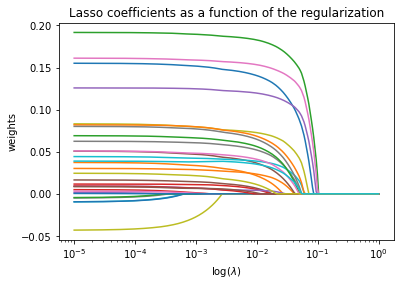

In [105]:
# Display results
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale("log")
plt.xlabel("$\log(\lambda)$")
plt.ylabel("weights")
plt.title("Lasso coefficients as a function of the regularization") 
plt.axis("tight")
plt.show()

I think the first line is non-monotonic because when log-lambda is very small, the LASSO solution should be very close to the OLS solution, and all coefficients are in the model. As log-lambda grows, the regularization term has greater effect and you will see fewer variables in your model (because more and more coefficients will be zero valued).

### Question 2.
*Run the cross-validated lasso (without standardization) based on the same set of variables.
Report the coefficient values for all non-zero coefficients at the optimal penalty value. What do the results
suggest regarding the scope for targeting?*

Obtain X and Y variables along with CV Lasso below:

In [85]:
# X variables to try for LASSO
X_2 = sparse.csc_matrix(demo_treat_matrix)

# Y variable for LASSO
Y_2 = ad_heterog['revenue']

# We run CV Lasso
nfolds  = 10
lassocv_1 = LassoCV(alphas = None, cv = nfolds, max_iter = 10000) #letting Lasso CV to choose alpha automatically
lassocv_1.fit(X_2,Y_2)

LassoCV(cv=10, max_iter=10000)

Define lassoCV plot function below:

In [71]:
def plot_lassoCV(lasso,nfolds):
     #1se rule 
    mean = np.mean(lasso.mse_path_, axis=1)
    std_error = np.std(lasso.mse_path_, axis=1)/np.sqrt(nfolds)
    mean_min  = mean[lasso.alphas_==lassocv.alpha_]
    std_min   = std_error[lasso.alphas_==lasso.alpha_]
    alpha_1se = np.max(lasso.alphas_[mean <= mean_min + std_min])

    # Plot    
    plt.semilogx(lassocv.alphas_, np.mean(lassocv.mse_path_, axis=1))

    plt.semilogx(lassocv.alphas_, mean + std_error, "b--")
    plt.semilogx(lassocv.alphas_, mean - std_error, "b--")
    plt.fill_between(lassocv.alphas_, mean + std_error, mean - std_error, alpha=0.2)
    plt.axvline(lassocv.alpha_, linestyle="--", color="black", label="$\lambda_{min}$")
    plt.axvline(alpha_1se, linestyle="--", color="red", label="$\lambda_{1se}$")
    plt.legend()
    plt.xlabel("$\log(\lambda)$")
    plt.ylabel("Mean Squared Error")
    plt.show() 

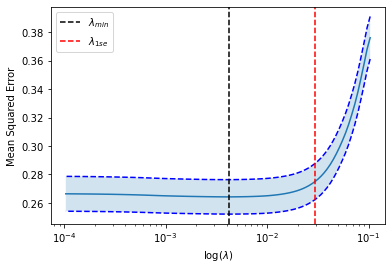

In [86]:
plot_lassoCV(lassocv_1,nfolds)

Get coefficient values for all non-zero coefficients below:

In [30]:
def get_coef(lasso,scale,coeffnames):
    # getting the coefficients and picking those that are not zero
    coefficients = np.append(lasso.intercept_, lasso.coef_/scale) 
    coeffnames = coeffnames[coefficients != 0]
    coeffvalues = coefficients[coefficients != 0]
    # return non-zero ones 
    return pd.DataFrame([coeffnames, coeffvalues]).T

In [87]:
coeffnames = list(demo_treat_matrix.columns)
coeffnames.insert(0,'(Intercept)')
coeffnames = np.array(coeffnames)
get_coef(lassocv_1,1,coeffnames)

,0,1
0,(Intercept),5.129393
1,treat_demo_1,0.146398
2,treat_demo_2,0.026282
3,treat_demo_3,0.1864
4,treat_demo_6,0.01105
5,treat_demo_7,0.15637
6,treat_demo_9,0.075364
7,treat_demo_12,0.028428
8,treat_demo_14,0.008927
9,treat_demo_15,0.004576


Results above suggest that our scope for targeting can be rather broad and capture many of the demographic groups in our original dataset considering most of the values for each treatment-demo interaction term are retained. However, 9 of our original 30 groups are missing from the non-zero coefficient list and those groups should therefore not be targeted.

## 3. Lasso with baseline and interacted demographics

### Question 1.
*Run a cross-validated lasso based on the same variables as above, but now also include the
un-interacted demographic variables to the matrix of X variables to try for lasso. Make sure you know how
to interpret the coefficients for the demographics that are selected as both slope and intercept dummies as
opposed to the demographics that only show up as interaction dummies. For example, consider the case of
demographics 3 and 7. Can you compute the treatment effect for both characteristics (i.e., the effect of the
treatment on individuals with a certain characteristic vs. individuals with the same characteristic in the
control group?).*

In [57]:
demo_and_treat = pd.concat([demo_matrix, demo_treat_matrix], axis=1)

In [58]:
# X variables to try for LASSO
X_3 = sparse.csc_matrix(demo_and_treat)

# Y variable for LASSO
Y_3 = ad_heterog['revenue']

# We run CV Lasso
nfolds  = 10
lassocv_2 = LassoCV(alphas = None, cv = nfolds, max_iter = 10000) #letting Lasso CV to choose alpha automatically
lassocv_2.fit(X_3,Y_3)

LassoCV(cv=10, max_iter=10000)

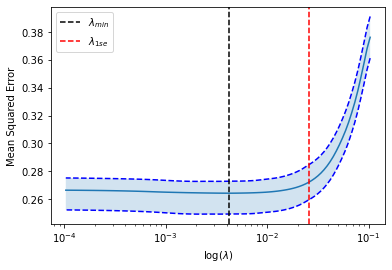

In [59]:
plot_lassoCV(lassocv_2,nfolds)

In [60]:
coeffnames_1 = list(demo_and_treat.columns)
coeffnames_1.insert(0,'(Intercept)')
coeffnames_1 = np.array(coeffnames_1)
get_coef(lassocv_2,1,coeffnames_1)

,0,1
0,(Intercept),5.130189
1,demographic_1,0.154537
2,demographic_2,-0.063791
3,demographic_3,-0.02355
4,demographic_5,-0.018032
5,demographic_7,0.014705
6,demographic_8,-0.007778
7,demographic_9,0.02767
8,demographic_11,-0.054
9,demographic_12,-0.019246


If we consider the example of demographic groups 3 and 7, we can compute treatment effect for both the treatment and control groups within this demographic. This is because in our coefficient list obtained above, we have both the interaction term and slope term for groups 3 and 7 which allows us to obtain non-zero values to estimate the effect of treatment on both groups.

### Question 2.
*For each observation, compute predicted revenue without and with treatment. Use those two
predictions to compute the expected profit per consumer when showing the ad to everybody versus when
showing the ad only to consumers with positive expected profit.*

In [117]:
ols_data = pd.concat([ad_heterog, demo_treat_matrix], axis=1)
ols_data = ols_data.drop(['demographic_4', 'demographic_6','demographic_10',
                          'demographic_14','demographic_18','demographic_19',
                          'demographic_21','demographic_24','demographic_26',
                          'demographic_27','demographic_29'],axis = 1)
ols_data = ols_data.drop(['treat_demo_1','treat_demo_4','treat_demo_10','treat_demo_17','treat_demo_21'],axis = 1)
ols_data

,revenue,treatment,demographic_1,demographic_2,demographic_3,demographic_5,demographic_7,demographic_8,demographic_9,demographic_11,...,treat_demo_20,treat_demo_22,treat_demo_23,treat_demo_24,treat_demo_25,treat_demo_26,treat_demo_27,treat_demo_28,treat_demo_29,treat_demo_30
0,5.504899,0,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,5.554275,1,0,1,1,0,1,0,1,1,...,1,0,0,1,1,0,1,1,1,0
2,5.219492,0,0,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.565855,0,1,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5.020636,0,1,1,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,6.685725,1,1,1,0,0,1,0,1,0,...,0,0,1,1,1,1,1,1,1,0
1996,6.707116,1,0,0,0,1,1,1,1,1,...,1,1,1,0,1,0,0,1,1,1
1997,5.522816,1,1,0,1,0,1,1,1,1,...,0,0,0,0,1,1,1,1,0,1
1998,4.787769,1,1,0,0,1,1,1,0,0,...,1,1,1,1,0,0,0,1,0,1


In [118]:
# second, we run the ols
all_columns = "+".join(ols_data.columns[1:])
my_formula = "revenue~" + all_columns

rev_reg = smf.ols(formula = my_formula, data = ols_data).fit()
print(rev_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     22.65
Date:                Sun, 06 Mar 2022   Prob (F-statistic):          8.41e-145
Time:                        19:03:46   Log-Likelihood:                -1442.0
No. Observations:                2000   AIC:                             2976.
Df Residuals:                    1954   BIC:                             3234.
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          5.0405      0.071     71.

Based on the regression above, our predicted revenue is 5.0405 without treatment and 5.3155 with treatment.